### Описание датасета и импорт библиотек

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median
import random
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной * здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### Обработка выбросов

In [3]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


 ##### *Сначала обработаем столбец Rooms, это поможет нам лучше заполнить пропуски*

In [4]:
df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Мы имеем 9 строк в которых значение Rooms = 0, и 4 строки Rooms = 6-19, присмотевшись повнимательнее, можно заметить, что эти строки имеют много выбросов и в других столбцах, а значит логично их будет просто удалить ввиду малого колличества

In [5]:
df = df.drop(df[df.Rooms == 0].index)
df = df.drop(df[df.Rooms > 5].index)

 ##### *поправим столбец KitchenSquare*

In [6]:
df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1073
6.0       1037
9.0        842
0.0        690
7.0        608
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

Строки, где площадь кухни меньше 5 можно считать выбросами, заполним их средними значениями исходя из колличества комнат

Для того, чтобы  получить наиболее адекватные значения в столбце "KitchenSquare" заполним пропуски с учётом колличества комнат

In [7]:
mean_KitchenSquare = pd.pivot_table(data=df,
            values='KitchenSquare',
           index='Rooms',
           aggfunc='mean')

In [8]:
def KitchenSquare_valid(df):
    # создаём столбец с пометкой об изменении данных
    df['KitchenSquare_valid'] = 0
    df.loc[df['KitchenSquare'] > 5, 'KitchenSquare_valid'] = 1
    
    # Заменяем значения на средние согласно колличеству комнат
    for i in range(1,6):
        df.loc[(df['KitchenSquare'] > 5)&(df['Rooms'] == i), 'KitchenSquare'] =\
        mean_KitchenSquare['KitchenSquare'][i]
    return df

 ##### *поправим столбец LifeSquare*

In [9]:
df[df['LifeSquare'] > df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


In [10]:
mean = np.mean(df['LifeSquare']/df['Square'][0])

In [11]:
def LifeSquare_normal(df):
    # создаём столбец с пометкой об изменении данных
    df['LifeSquare_normal'] = 0
    df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare_normal'] = 1
    
    df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] =\
         df['Square']*mean
        
    return df

##### Посмотрим на зависимость цены квартиры от этажа

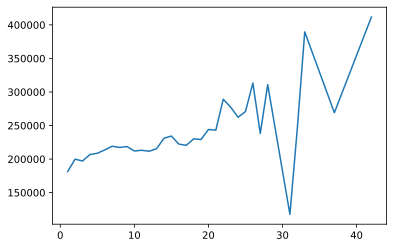

In [12]:
plt.plot(pd.pivot_table(data=df,
               values='Price',
               index='Floor',
               aggfunc='mean'))

plt.show()

In [13]:
df[df['Floor'] == 31]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
765,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002


строка, с квартирой на 31ом этаже имеет сильно заниженную цену, удалим эту строку, как выброс

In [14]:
df = df.drop(df[df.Floor == 31].index)

##### Посмотрим на зависимость цены квартиры от колличества этажей в доме

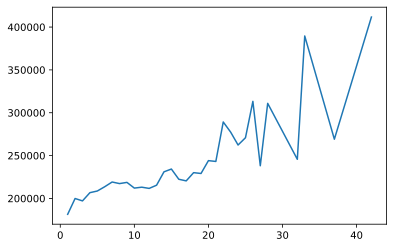

In [15]:
plt.plot(pd.pivot_table(data=df,
               values='Price',
               index='Floor',
               aggfunc='mean'))
plt.show()

Были обнаружены выбросы, для начала избавимся от них

In [16]:
df[df.HouseFloor > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


Таких значений всего 3 и проще их удалить

In [17]:
df = df.drop(df[df.HouseFloor > 50].index)

##### Далее истравим выбросы в колонке с возрастом дома

In [18]:
df[(df['HouseYear'] > 2021)|(df['HouseYear'] < 1910)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


In [19]:
# выбросов всего 2, поэтому удалим их
df = df.drop(df[(df['HouseYear'] > 2021)|(df['HouseYear'] < 1910)].index)

 ##### *Найдём и заполним пропуски*

In [20]:
df.count(
)[df.count() < 9988].index

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

##### LifeSquare

Для того, чтобы  получить наиболее адекватные значения в столбце "LifeSquare" заполним пропуски с учётом колличества комнат

In [21]:
    mean_LifeSquare = pd.pivot_table(data=df,
               values='LifeSquare',
               index='Rooms',
               aggfunc='mean')

In [22]:
def LifeSquare_not_nan(df):
    # создаём столбец с пометкой об изменении данных
    df['LifeSquare_nan'] = 0
    df.loc[df['LifeSquare_nan'] > 5, 'LifeSquare_nan'] = 1

    for i in range(1,6):
        df.loc[((df['LifeSquare'] < 5)&(df['Rooms'] == i))|((df.LifeSquare.isna())&(df['Rooms'] == i)), 'LifeSquare'] =\
        mean_LifeSquare['LifeSquare'][i]
        
    return df

In [23]:
df['Healthcare_1'].isna().sum()

4789

##### *Так как пропущеных значений в колонке Healthcare_1 почти половина, мы не можем заменить эти значения медианой или средним значением, так как скорее всего это не ошибка данных, а конкретное значение, несущее смысл. Поэтому заменим все значения Null на 0*

In [24]:
def Healthcare_1_valid(df):
    df['Healthcare_1'] = df['Healthcare_1'].fillna(0)
    return df

##### Найдём те квартиры, номер этажа которых больше, чем колличество этажей в доме

In [25]:
(df['HouseFloor'] < df['Floor']).value_counts()

False    8163
True     1819
dtype: int64

Мы видим, что в 1819 случаях унас указан отсутствующий в доме этаж, нам надо решить, как именно исправить эту ошибку, для этого выясним, от чего цена квартиры зависит сильнее, от этажа или колличесства этажей в доме

Text(0.5, 1.0, 'HouseFloor')

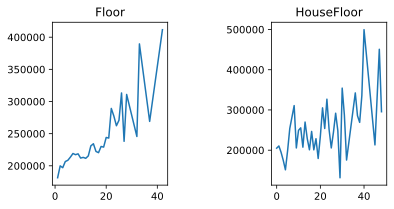

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(6, 3)
fig.subplots_adjust(wspace=0.9)
fig.subplots_adjust(hspace=0.3)

ax[0].plot(pd.pivot_table(data=df,
               values='Price',
               index='Floor',
               aggfunc='mean'))
ax[0].set_title("Floor")
ax[1].plot(pd.pivot_table(data=df,
               values='Price',
               index='HouseFloor',
               aggfunc='mean'))
ax[1].set_title("HouseFloor")

Итак, мы однозначно выяснили, что меньшшее влияние на цену оказывает колличество этажей в доме, чем этаж квартиры, а значит именно его мы и будеми изменять.

In [27]:
def HouseFloor_valid(df):
    # создаём столбец с пометкой об изменении данных
    df['HouseFloor_valid']=0
    df.loc[df['HouseFloor'] < df['Floor'],'HouseFloor_valid']=1
    
    df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor'] = \
    df.loc[df['HouseFloor'] < df['Floor'], 'Floor'].apply(lambda x: random.randint(x, 48))
    return df

##### Превратим признаки 'Shops_2','Ecology_2','Ecology_3' в бинарные

In [28]:
def to_bin(df):
    l = ['Shops_2','Ecology_2','Ecology_3']
    for i in l:
        df.loc[df[i] == 'A', i] = 0
        df.loc[df[i] == 'B', i] = 1
    return df

Удалим Id и оптимизируем память

In [29]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    df.drop(columns=['Id'], inplace=True)
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [30]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(8,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [31]:
def transform(df):
    """Трансформация данных"""
    KitchenSquare_valid(df)
    LifeSquare_not_nan(df)
    LifeSquare_normal(df)
    Healthcare_1_valid(df)
    HouseFloor_valid(df)
    to_bin(df)
    return df

### Преобразования


In [32]:
transform(df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,KitchenSquare_valid,LifeSquare_nan,LifeSquare_normal,HouseFloor_valid
0,11809,27,3.0,115.027311,54.942865,6.801790,4,10.0,2014,0.075424,...,0,0.0,0,0,1,305018.871089,1,0,0,0
1,3013,22,1.0,39.832524,23.169223,6.525776,7,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,1,0,0,0
2,8215,1,3.0,78.342215,47.671972,6.801790,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,1,0,0,0
3,2352,1,1.0,40.409907,25.142618,1.000000,10,22.0,1977,0.007122,...,0,0.0,0,1,1,168106.007630,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,5.636340,16,16.0,1972,0.282798,...,2,0.0,0,6,1,343995.102962,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,5.636340,3,12.0,1981,0.300323,...,6,0.0,1,9,1,119367.455796,1,0,0,0
9996,16265,27,2.0,64.307684,37.038420,5.636340,13,29.0,1977,0.072158,...,1,0.0,0,0,0,199715.148807,1,0,0,1
9997,2795,178,1.0,29.648057,16.555363,5.000000,3,5.0,1958,0.460556,...,14,0.0,1,5,1,165953.912580,0,0,0,0
9998,14561,21,1.0,32.330292,22.326870,5.000000,3,9.0,1969,0.194489,...,3,125.0,3,5,1,171842.411855,0,0,0,0


In [33]:
df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare             0
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1           0
Helthcare_2            0
Shops_1                0
Shops_2                0
Price                  0
KitchenSquare_valid    0
LifeSquare_nan         0
LifeSquare_normal      0
HouseFloor_valid       0
dtype: int64

### Разбиение на Train и Test

In [34]:
target_name = 'Price'
train_df = df
X = train_df.drop(columns=target_name)
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Обучение

In [35]:
rb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50, 
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
rb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250)

# Тест

Train R2:	0.862
Test R2:	0.75


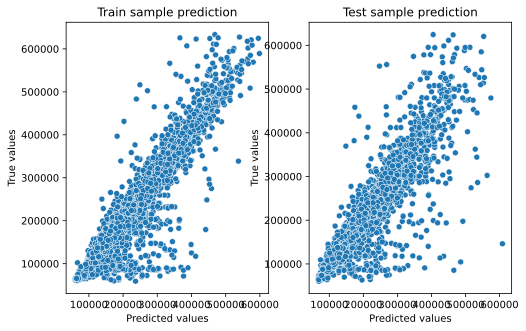

In [36]:
y_train_preds = rb_model.predict(X_train)
y_test_preds = rb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Сделаем предсказанние на тестовом датасете

In [37]:
test = pd.read_csv('test.csv')
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [38]:
test = pd.read_csv('test.csv')
test.loc[test.Id == 10793, 'Rooms'] = 5
test.loc[test.Floor > 48, 'Floor'] = 45
transform(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,KitchenSquare_valid,LifeSquare_nan,LifeSquare_normal,HouseFloor_valid
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,...,4378,0,1036.0,1,1,1,0,0,0,0
1,5925,62,1.0,42.493907,13.730591,6.525776,7,17.0,2017,0.072158,...,629,1,0.0,0,0,0,1,0,1,0
2,960,27,2.0,59.463678,35.951614,5.636340,19,19.0,1977,0.211401,...,1892,0,0.0,0,1,1,1,0,0,0
3,3848,23,3.0,49.646030,33.893825,6.801790,2,2.0,1965,0.014073,...,475,0,0.0,0,0,1,1,0,0,0
4,746,74,1.0,53.837056,25.142618,1.000000,8,17.0,1977,0.309479,...,7715,4,990.0,0,6,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.000000,6,31.0,1962,0.069660,...,6119,4,0.0,1,2,1,0,0,0,1
4996,16138,38,3.0,93.698122,30.275648,6.801790,21,27.0,2018,0.060753,...,2787,2,520.0,0,7,1,1,0,1,0
4997,3912,101,1.0,33.656723,19.003259,5.000000,2,5.0,1966,0.038693,...,6533,1,1015.0,2,5,1,0,0,0,0
4998,5722,10,1.0,38.635155,20.976257,6.525776,8,14.0,1970,0.089040,...,7976,5,0.0,0,11,1,1,0,0,0


In [39]:
test_preds = rb_model.predict(test)

In [40]:
submit = pd.read_csv('sample_submission.csv')

In [41]:
submit['Price'] = test_preds
submit.head()

,Id,Price
0,4567,169193.315399
1,5925,111619.288167
2,960,149055.618567
3,3848,119536.460025
4,746,195437.898365


In [53]:
submit.to_csv('Test-Pred.csv', index = False)